# EDA Analysis

This notebook performs Exploratory Data Analysis (EDA) on the 8 unknown functions for the Black-Box Optimization Capstone project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from utils import load_data
from sklearn.ensemble import RandomForestRegressor
import warnings
import pandas as pd

%matplotlib inline

In [9]:
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Create plots directory
if not os.path.exists('eda_plots'):
    os.makedirs('eda_plots')

## Analysis Helper Function

In [10]:
def analyze_function_data(function_id):
    print(f"\n{'='*40}")
    print(f"ANALYZING FUNCTION {function_id}")
    print(f"{'='*40}")

    # 1. Load Data
    inputs, outputs = load_data(function_id)

    if inputs is None:
        print(f"Function {function_id}: Data not found.")
        return

    n_samples, n_features = inputs.shape

    # 2. Basic Info
    print(f"Dimensionality: {n_features}D")
    print(f"Samples: {n_samples}")

    # Check missing
    missing_inputs = np.isnan(inputs).sum()
    missing_outputs = np.isnan(outputs).sum()
    if missing_inputs > 0 or missing_outputs > 0:
        print(f"WARNING: Missing values - Inputs: {missing_inputs}, Outputs: {missing_outputs}")

    # 3. Descriptive Statistics (Using Pandas for nice display)
    stats_data = []
    for i in range(n_features):
        feat = inputs[:, i]
        stats_data.append({
            "Feature": f"X{i+1}",
            "Mean": np.mean(feat),
            "Std": np.std(feat),
            "Min": np.min(feat),
            "Max": np.max(feat),
            "Zero Variance": np.std(feat) == 0
        })

    # Add Target info
    stats_data.append({
        "Feature": "Target (Y)",
        "Mean": np.mean(outputs),
        "Std": np.std(outputs),
        "Min": np.min(outputs),
        "Max": np.max(outputs),
        "Zero Variance": False
    })

    df_stats = pd.DataFrame(stats_data)
    display(df_stats) # Using display() for pretty dataframe printing

    # 4. Return data for plotting and further analysis in next cells
    return inputs, outputs, n_features

## Visualization Function

In [11]:
def visualize_data(function_id, inputs, outputs, n_features):
    # --- Target Distribution ---
    plt.figure(figsize=(12, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(outputs, bins=15, color='skyblue', edgecolor='black')
    plt.title(f'Function {function_id}: Target Distribution')
    plt.xlabel('Y')
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot(outputs, vert=False)
    plt.title(f'Function {function_id}: Target Boxplot')
    plt.xlabel('Y')

    plt.tight_layout()
    plt.show()

    # --- Scatter Plots (Feature vs Target) ---
    if n_features == 2:
        # 3D Plot for 2D inputs
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        sc = ax.scatter(inputs[:, 0], inputs[:, 1], outputs, c=outputs, cmap='viridis')
        plt.colorbar(sc, label='Y')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        plt.title(f'Function {function_id}: 3D Surface Visualization')
        plt.show()
    else:
        # Subplots for > 2D
        n_cols = 3
        n_rows = (n_features + n_cols - 1) // n_cols

        plt.figure(figsize=(15, 4 * n_rows))
        for i in range(n_features):
            plt.subplot(n_rows, n_cols, i+1)
            plt.scatter(inputs[:, i], outputs, alpha=0.6, s=15)
            plt.xlabel(f'X{i+1}')
            plt.ylabel('Y')
            plt.title(f'X{i+1} vs Y')

        plt.tight_layout()
        plt.show()

## Feature Importance & Correlation Function

In [12]:
def analyze_relationships(inputs, outputs):
    # 1. Correlations (Pearson)
    # Combine inputs and outputs for correlation matrix
    data_combined = np.hstack((inputs, outputs.reshape(-1, 1)))
    corr_matrix = np.corrcoef(data_combined, rowvar=False)
    target_corr = corr_matrix[:-1, -1] # Correlation of inputs with target

    print("\n--- Pearson Correlations (X vs Y) ---")
    corr_list = []
    for i, corr in enumerate(target_corr):
        strength = "**STRONG**" if abs(corr) > 0.5 else ""
        corr_list.append({"Feature": f"X{i+1}", "Correlation": corr, "Note": strength})

    display(pd.DataFrame(corr_list))

    # 2. Feature Importance (Random Forest)
    print("\n--- Random Forest Feature Importance ---")
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(inputs, outputs.ravel())
    importances = rf.feature_importances_

    # Sort and display
    indices = np.argsort(importances)[::-1]

    imp_list = []
    for f in range(inputs.shape[1]):
        imp_list.append({
            "Rank": f+1,
            "Feature": f"X{indices[f]+1}",
            "Importance": importances[indices[f]]
        })

    display(pd.DataFrame(imp_list))

## Main


ANALYZING FUNCTION 1
Dimensionality: 2D
Samples: 10


,Feature,Mean,Std,Min,Max,Zero Variance
0,X1,0.548817,0.245861,0.082507,8.838898e-01,False
1,X2,0.539519,0.280817,0.078723,8.798981e-01,False
2,Target (Y),-0.000361,0.001082,-0.003606,7.710875e-16,False


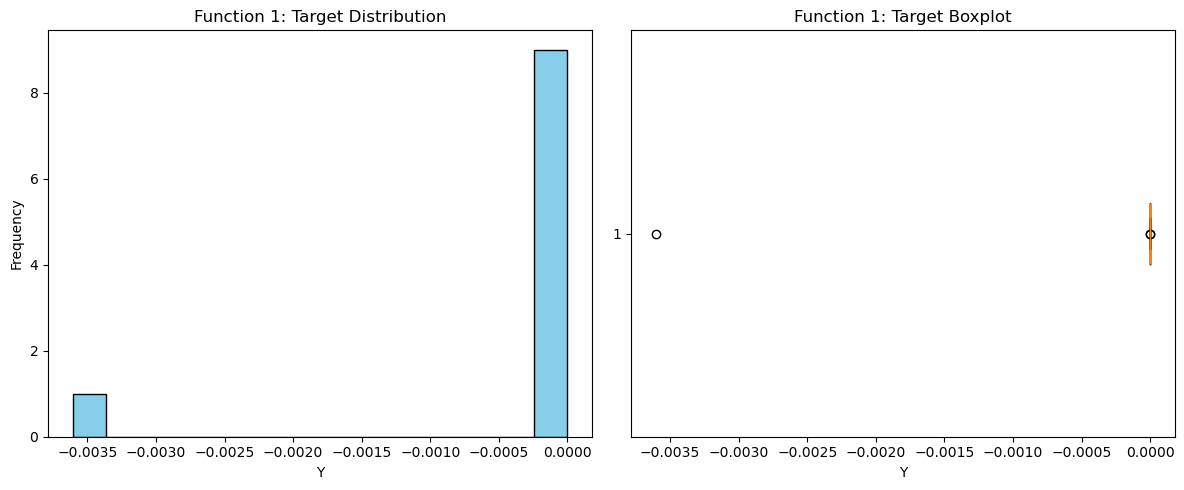

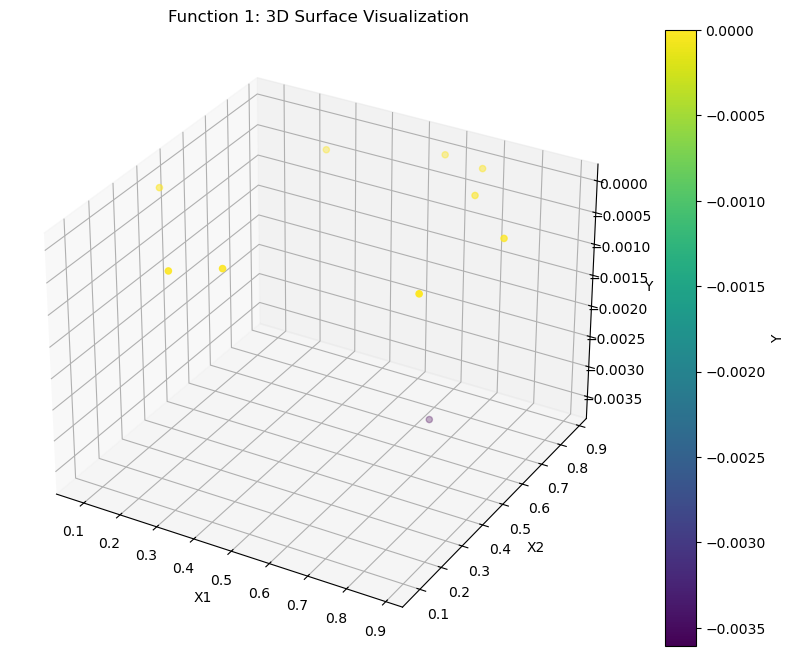


--- Pearson Correlations (X vs Y) ---


,Feature,Correlation,Note
0,X1,-0.137337,
1,X2,-0.168565,



--- Random Forest Feature Importance ---


,Rank,Feature,Importance
0,1,X2,0.535126
1,2,X1,0.464874



ANALYZING FUNCTION 2
Dimensionality: 2D
Samples: 10


,Feature,Mean,Std,Min,Max,Zero Variance
0,X1,0.538513,0.225016,0.142699,0.877791,False
1,X2,0.487930,0.303811,0.028698,0.926564,False
2,Target (Y),0.230674,0.225365,-0.065624,0.611205,False


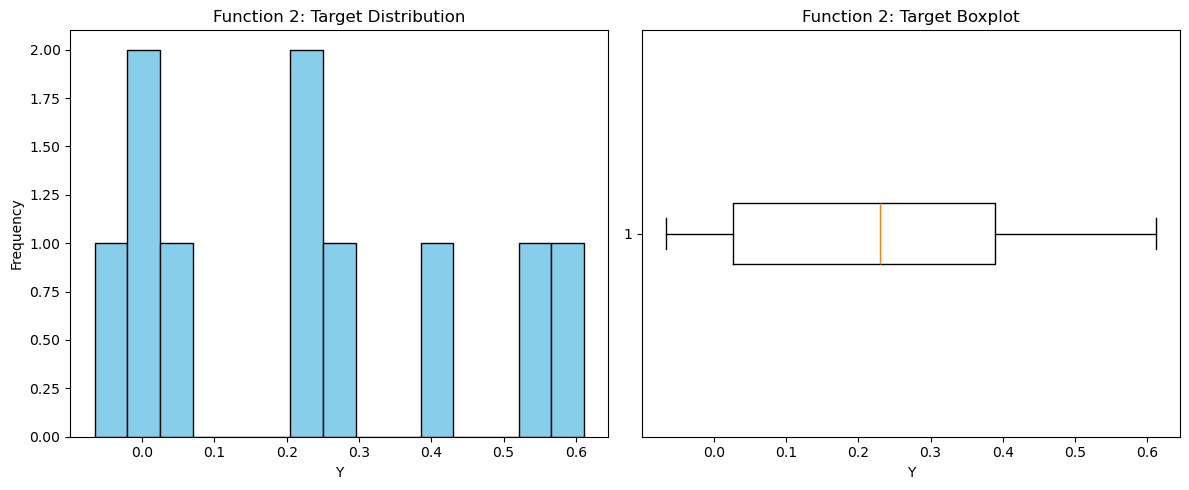

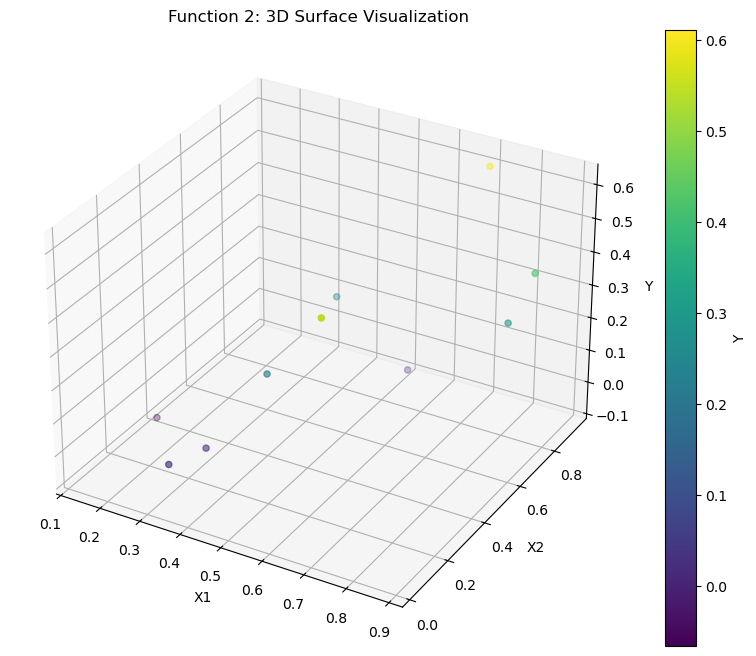


--- Pearson Correlations (X vs Y) ---


,Feature,Correlation,Note
0,X1,0.751823,**STRONG**
1,X2,0.390322,



--- Random Forest Feature Importance ---


,Rank,Feature,Importance
0,1,X1,0.768816
1,2,X2,0.231184



ANALYZING FUNCTION 3
Dimensionality: 3D
Samples: 15


,Feature,Mean,Std,Min,Max,Zero Variance
0,X1,0.409031,0.265713,0.046809,0.965995,False
1,X2,0.517677,0.225051,0.219917,0.941360,False
2,X3,0.402788,0.274507,0.066089,0.990882,False
3,Target (Y),-0.107167,0.084214,-0.398926,-0.034835,False


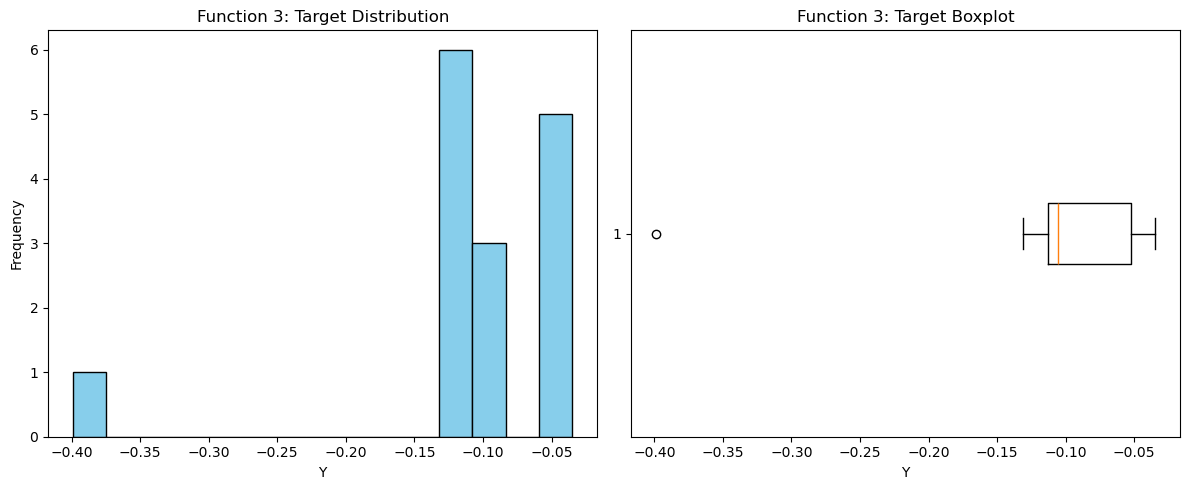

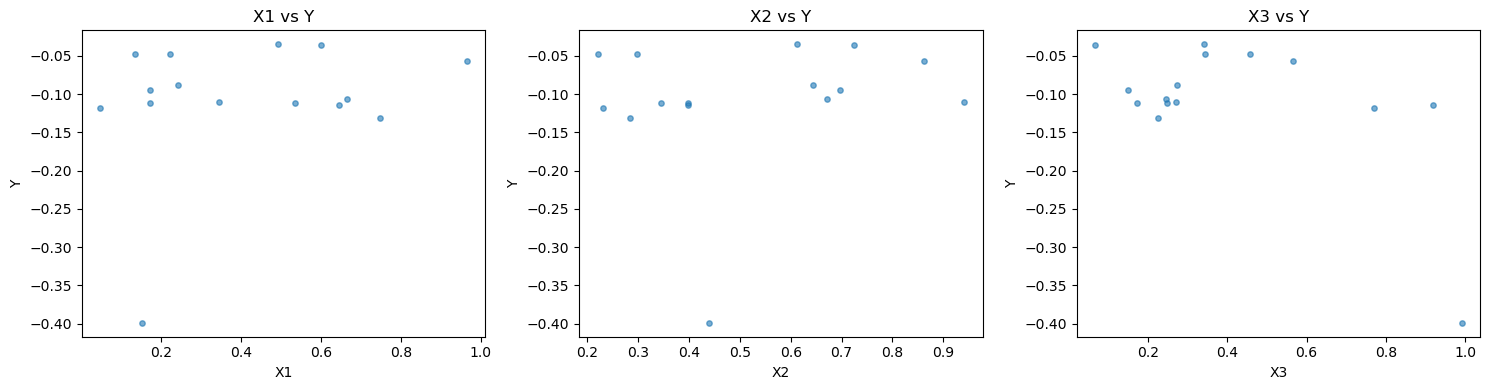


--- Pearson Correlations (X vs Y) ---


,Feature,Correlation,Note
0,X1,0.250607,
1,X2,0.158439,
2,X3,-0.573676,**STRONG**



--- Random Forest Feature Importance ---


,Rank,Feature,Importance
0,1,X3,0.797616
1,2,X2,0.112040
2,3,X1,0.090344



ANALYZING FUNCTION 4
Dimensionality: 4D
Samples: 30


,Feature,Mean,Std,Min,Max,Zero Variance
0,X1,0.542872,0.289066,0.037825,0.985622,False
1,X2,0.477129,0.303718,0.006250,0.919592,False
2,X3,0.465693,0.257221,0.042186,0.939178,False
3,X4,0.474096,0.287497,0.081517,0.999483,False
4,Target (Y),-17.238587,7.017985,-32.625660,-4.025542,False


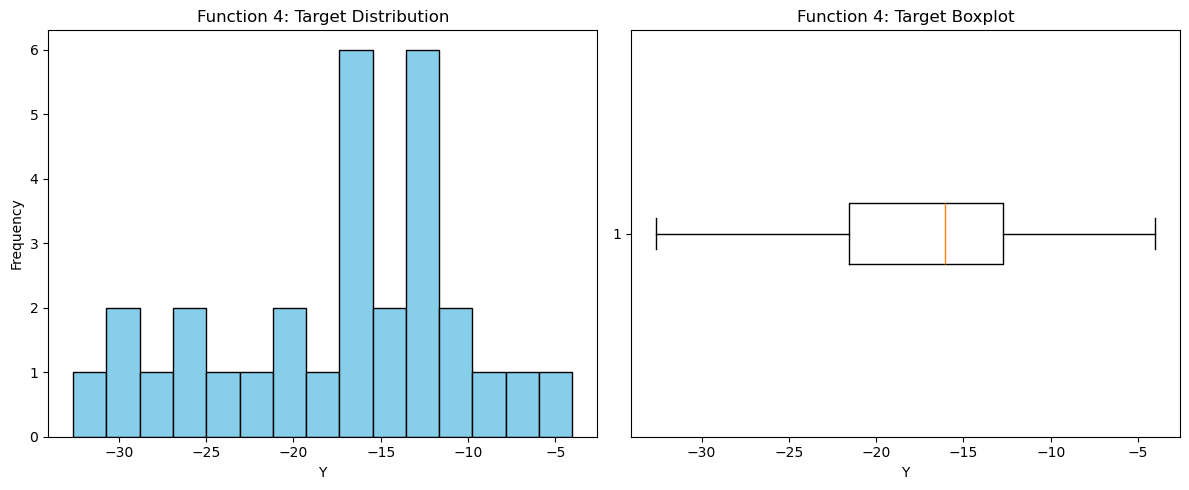

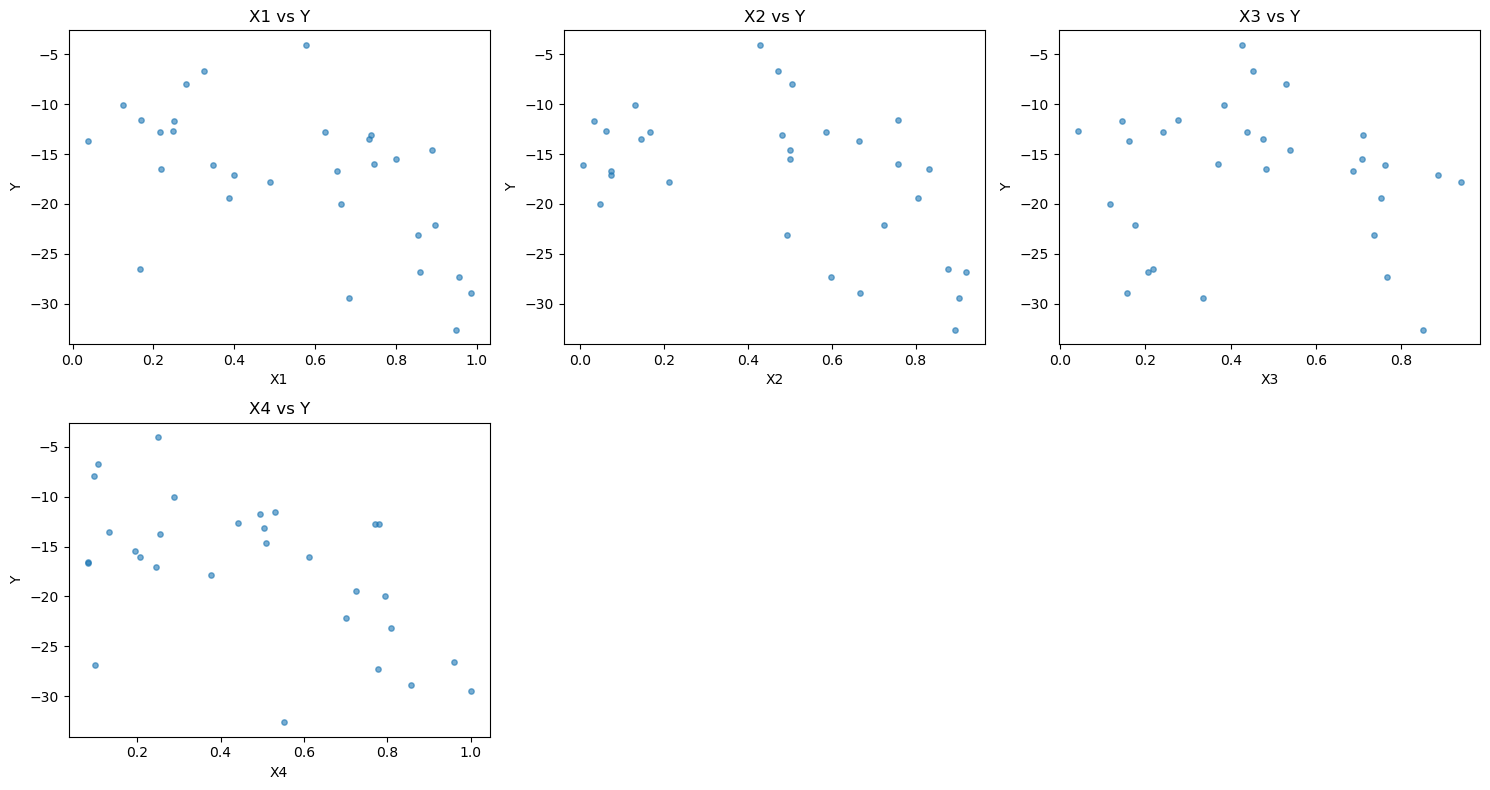


--- Pearson Correlations (X vs Y) ---


,Feature,Correlation,Note
0,X1,-0.539888,**STRONG**
1,X2,-0.484809,
2,X3,-0.084794,
3,X4,-0.532115,**STRONG**



--- Random Forest Feature Importance ---


,Rank,Feature,Importance
0,1,X1,0.306773
1,2,X2,0.302788
2,3,X4,0.279757
3,4,X3,0.110682



ANALYZING FUNCTION 5
Dimensionality: 4D
Samples: 20


,Feature,Mean,Std,Min,Max,Zero Variance
0,X1,0.460387,0.221453,0.119879,0.836478,False
1,X2,0.498557,0.266691,0.038193,0.862540,False
2,X3,0.477944,0.240548,0.088947,0.879484,False
3,X4,0.494719,0.300647,0.072880,0.957644,False
4,Target (Y),151.271876,245.575981,0.112940,1088.859618,False


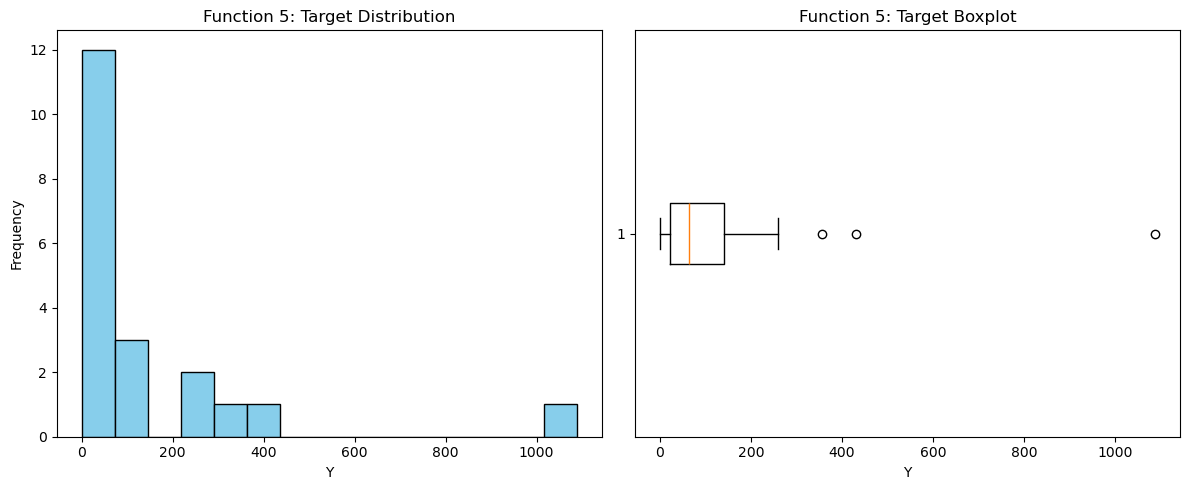

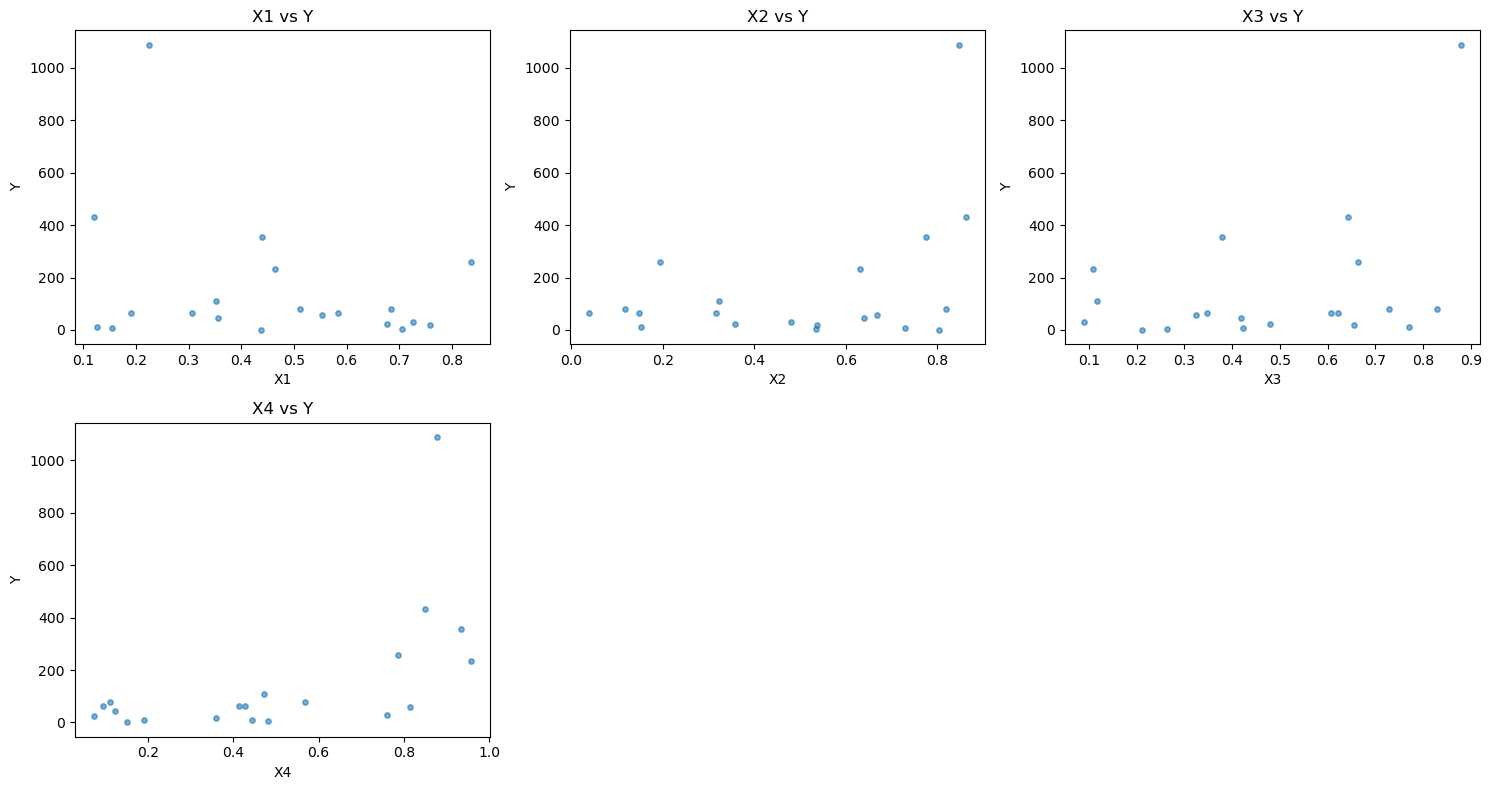


--- Pearson Correlations (X vs Y) ---


,Feature,Correlation,Note
0,X1,-0.284356,
1,X2,0.389340,
2,X3,0.367304,
3,X4,0.569877,**STRONG**



--- Random Forest Feature Importance ---


,Rank,Feature,Importance
0,1,X3,0.457033
1,2,X4,0.381144
2,3,X2,0.105125
3,4,X1,0.056699



ANALYZING FUNCTION 6
Dimensionality: 5D
Samples: 20


,Feature,Mean,Std,Min,Max,Zero Variance
0,X1,0.547765,0.295342,0.021735,0.957740,False
1,X2,0.562570,0.276435,0.114404,0.931871,False
2,X3,0.467217,0.307308,0.016523,0.978806,False
3,X4,0.534433,0.273163,0.045613,0.961656,False
4,X5,0.423745,0.289673,0.004911,0.892819,False
5,Target (Y),-1.495390,0.449000,-2.571170,-0.714265,False


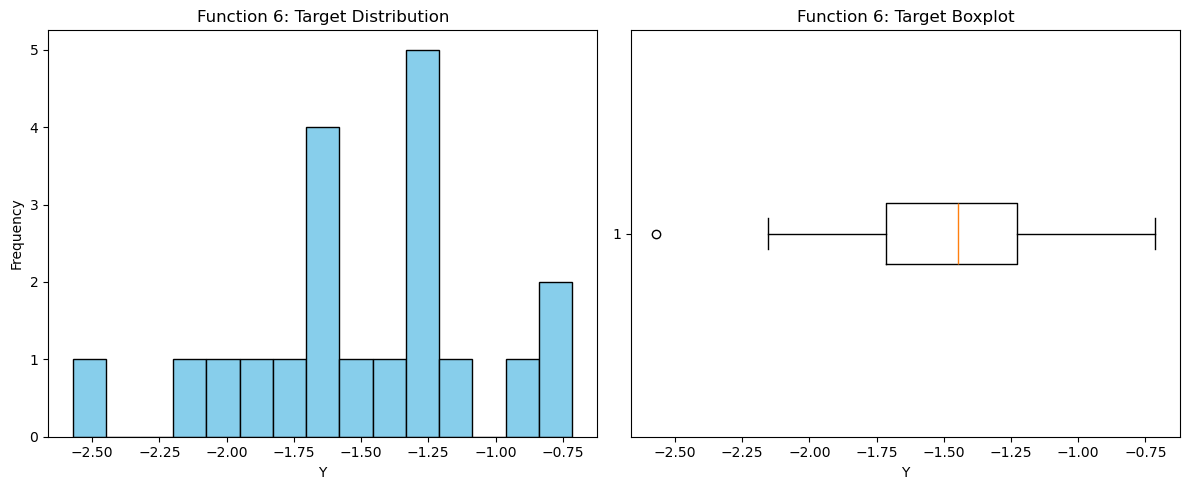

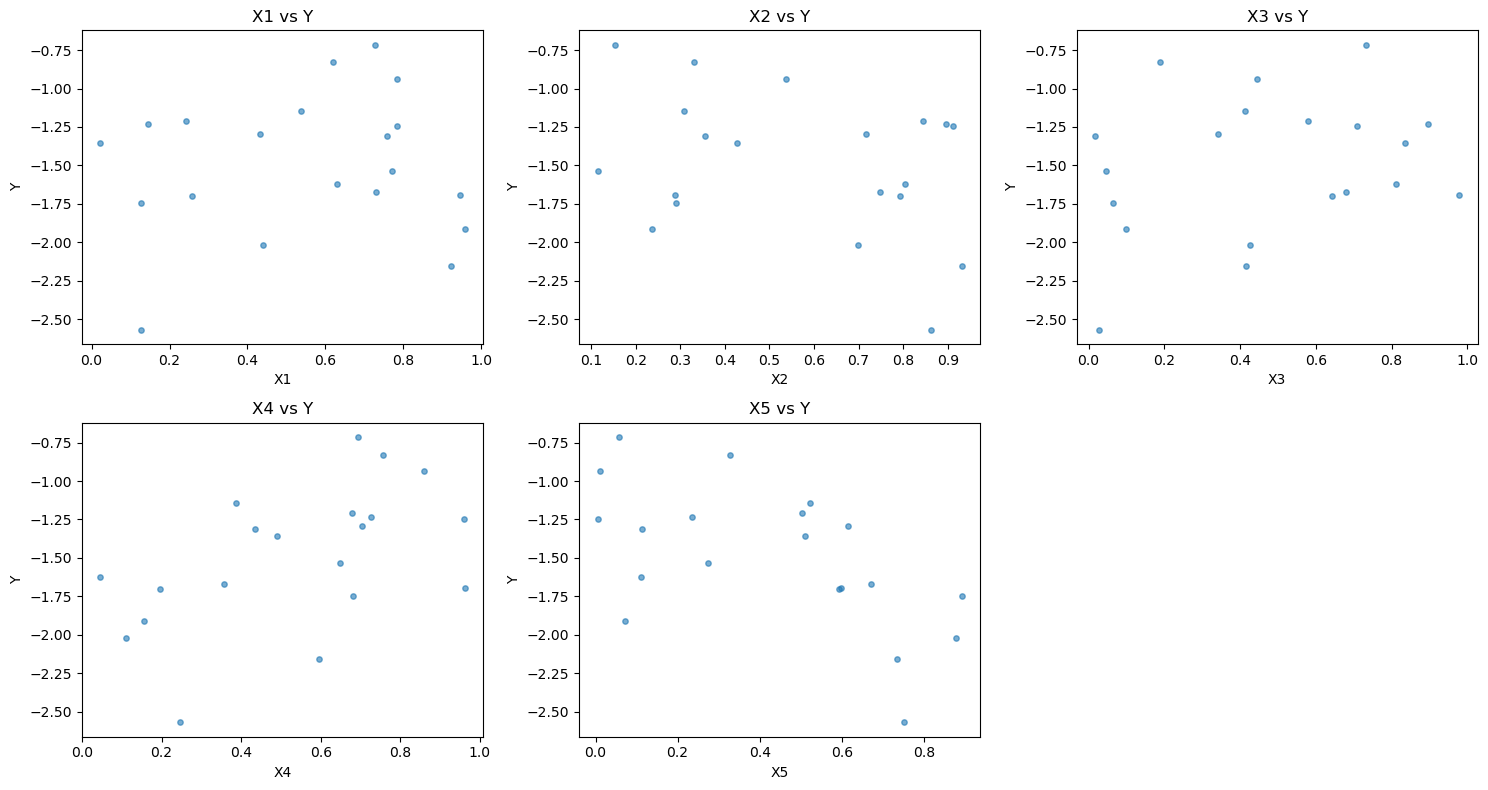


--- Pearson Correlations (X vs Y) ---


,Feature,Correlation,Note
0,X1,0.095408,
1,X2,-0.330443,
2,X3,0.258627,
3,X4,0.528466,**STRONG**
4,X5,-0.584018,**STRONG**



--- Random Forest Feature Importance ---


,Rank,Feature,Importance
0,1,X5,0.441197
1,2,X4,0.246001
2,3,X2,0.125285
3,4,X1,0.109772
4,5,X3,0.077744



ANALYZING FUNCTION 7
Dimensionality: 6D
Samples: 30


,Feature,Mean,Std,Min,Max,Zero Variance
0,X1,0.510852,0.298837,0.057896,0.942451,False
1,X2,0.395803,0.248334,0.011813,0.924694,False
2,X3,0.389609,0.308763,0.003635,0.924571,False
3,X4,0.512819,0.306722,0.073659,0.961017,False
4,X5,0.467201,0.309443,0.014944,0.998655,False
5,X6,0.484704,0.264816,0.051100,0.951014,False
6,Target (Y),0.219607,0.302129,0.002701,1.364968,False


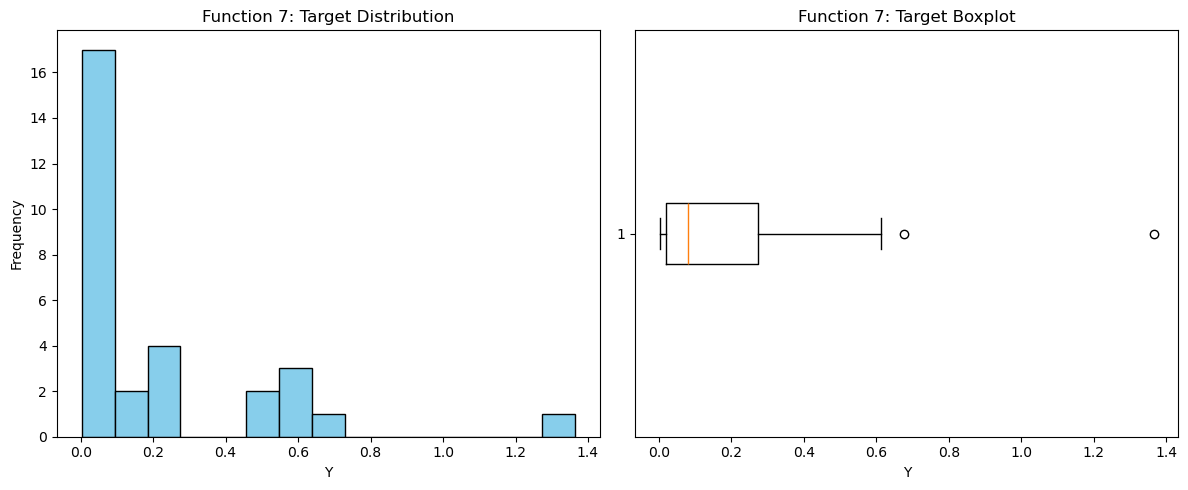

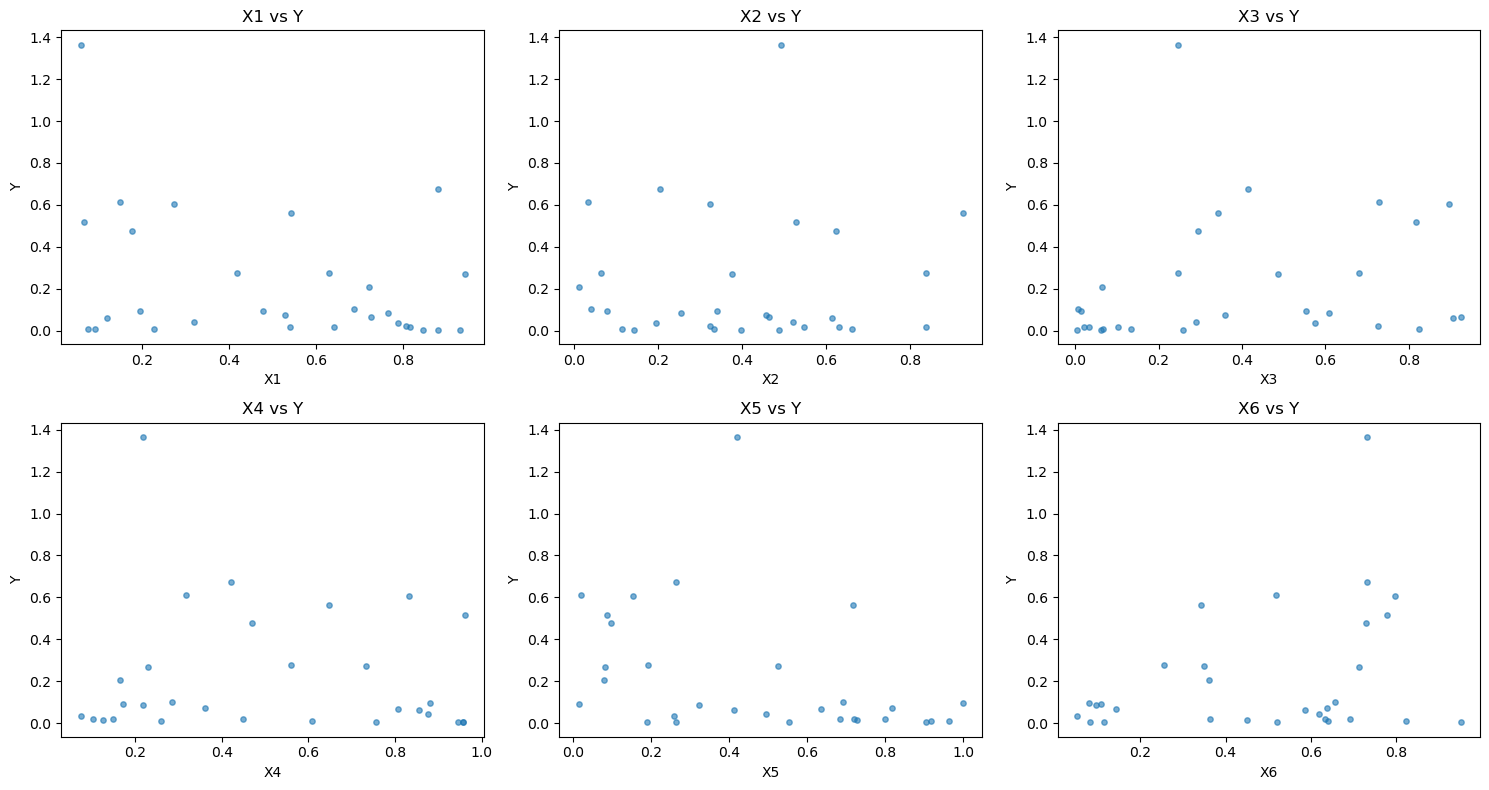


--- Pearson Correlations (X vs Y) ---


,Feature,Correlation,Note
0,X1,-0.343224,
1,X2,0.048185,
2,X3,0.177308,
3,X4,-0.075984,
4,X5,-0.377932,
5,X6,0.307256,



--- Random Forest Feature Importance ---


,Rank,Feature,Importance
0,1,X1,0.375528
1,2,X6,0.213315
2,3,X5,0.208579
3,4,X2,0.131431
4,5,X3,0.047587
5,6,X4,0.023560



ANALYZING FUNCTION 8
Dimensionality: 8D
Samples: 40


,Feature,Mean,Std,Min,Max,Zero Variance
0,X1,0.534609,0.306768,0.009077,0.985945,False
1,X2,0.472150,0.305810,0.003419,0.973980,False
2,X3,0.515970,0.278887,0.022929,0.998885,False
3,X4,0.430449,0.258190,0.009043,0.902986,False
4,X5,0.468951,0.277841,0.009649,0.986902,False
5,X6,0.460126,0.273887,0.022113,0.990244,False
6,X7,0.579196,0.254669,0.035909,0.992914,False
7,X8,0.506720,0.277808,0.041956,0.988755,False
8,Target (Y),7.815274,0.946903,5.592193,9.598482,False


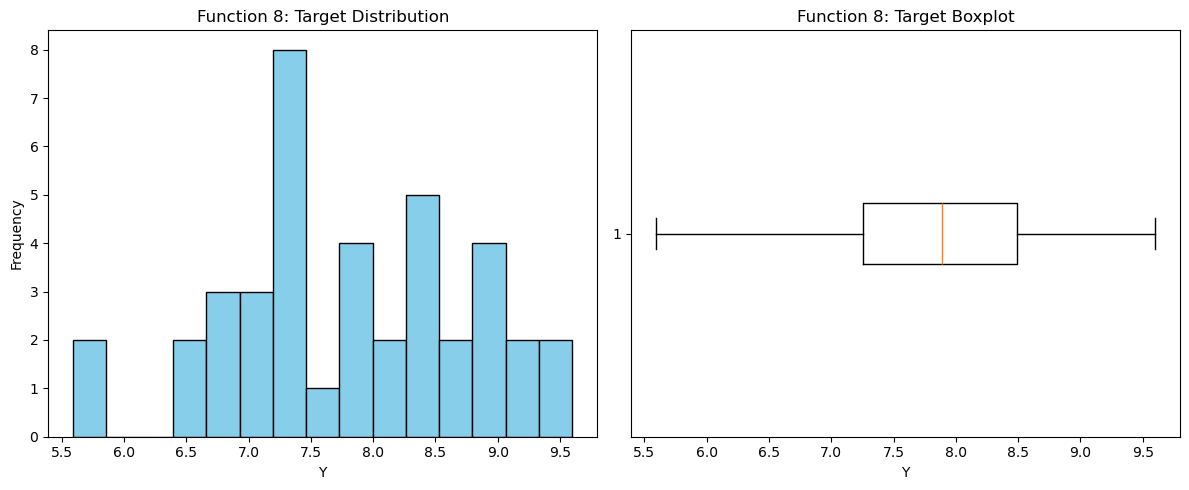

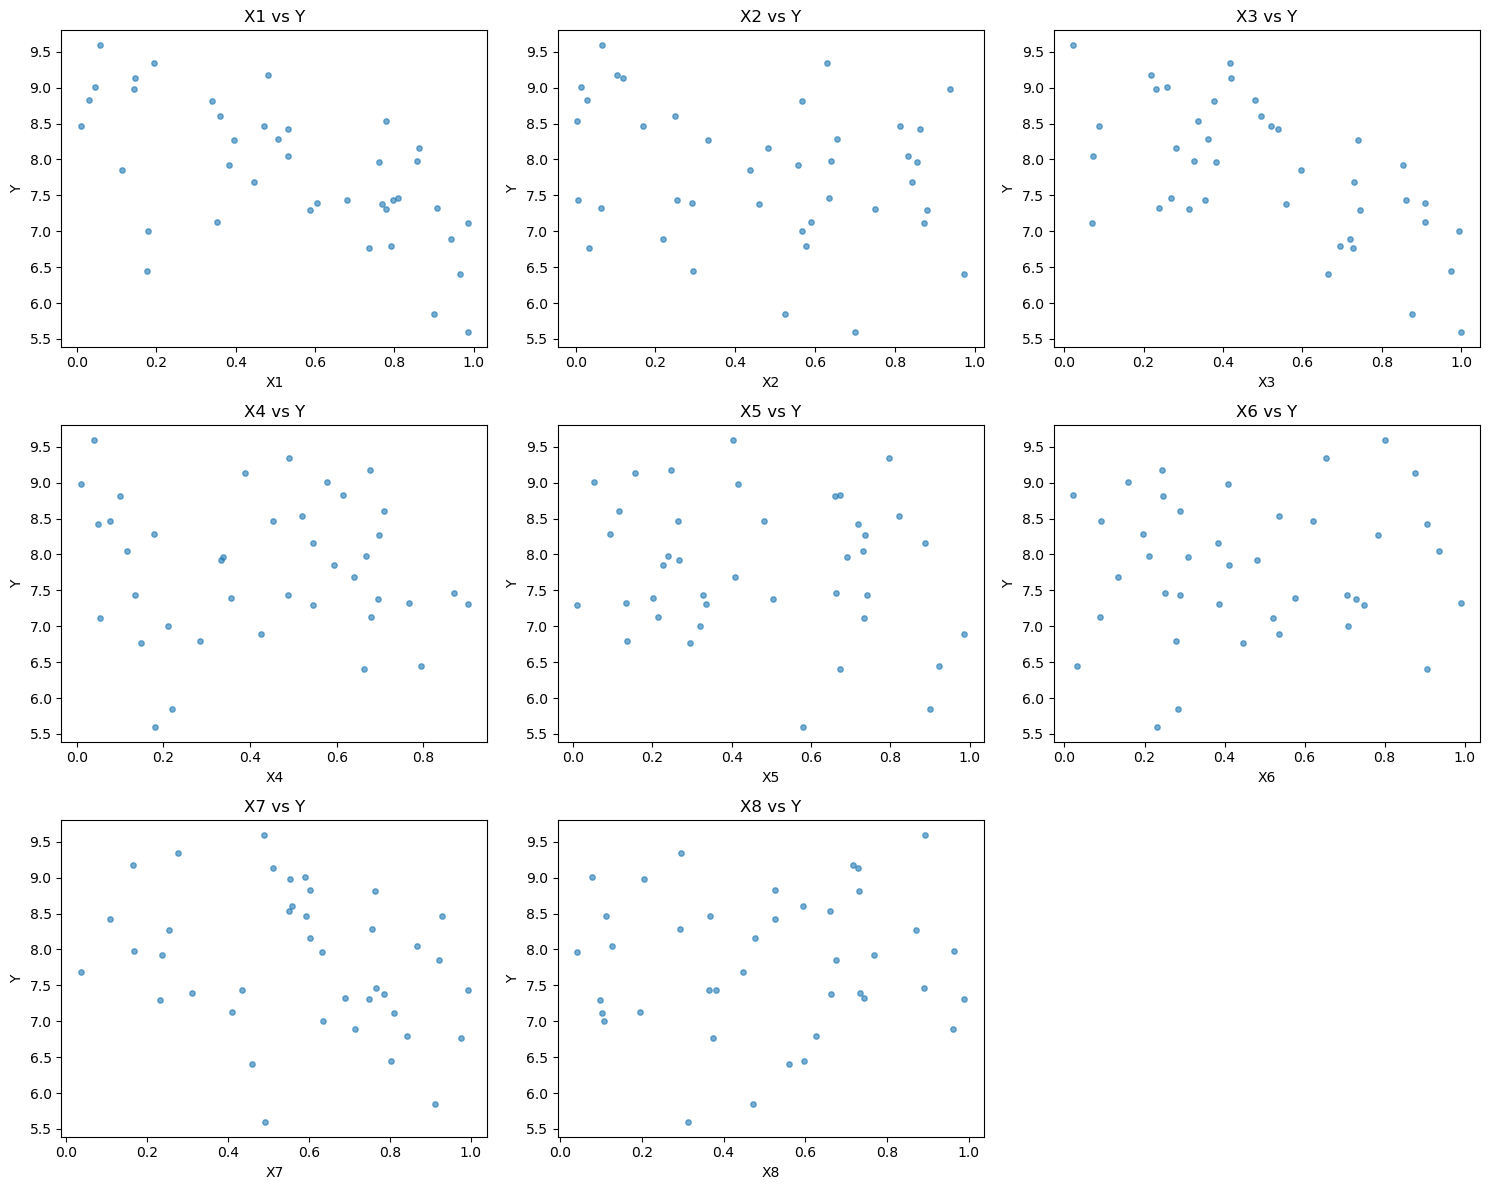


--- Pearson Correlations (X vs Y) ---


,Feature,Correlation,Note
0,X1,-0.625861,**STRONG**
1,X2,-0.235349,
2,X3,-0.622894,**STRONG**
3,X4,-0.072546,
4,X5,-0.169340,
5,X6,0.067227,
6,X7,-0.289269,
7,X8,0.053484,



--- Random Forest Feature Importance ---


,Rank,Feature,Importance
0,1,X3,0.455180
1,2,X1,0.297294
2,3,X7,0.110510
3,4,X5,0.040074
4,5,X8,0.032305
5,6,X2,0.023772
6,7,X6,0.020460
7,8,X4,0.020404


In [15]:
# Iterate through all 8 functions
for func_id in range(1, 9):
    # Step 1: Analyze Stats
    result = analyze_function_data(func_id)

    if result:
        inputs, outputs, n_features = result

        # Step 2: Visualize
        visualize_data(func_id, inputs, outputs, n_features)

        # Step 3: Relationships
        analyze_relationships(inputs, outputs)